<a href="https://colab.research.google.com/github/jkranyak/project_3/blob/second_model/Cancer_Net_SCa_SecondModel_Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow
!pip install isic-cli
!pip install kaggle
# !pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.7/223.7 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.3 MB/s eta 0:00:00


In [3]:
import random
import numpy as np
import tensorflow as tf

# Set random seeds for Python's built-in random number generator
random.seed(42)

# Set random seeds for NumPy's random number generator
np.random.seed(42)

# Set random seeds for TensorFlow's random number generator
tf.random.set_seed(42)


In [4]:
import os
# Specify the current path of kaggle.json file
current_path = '/content/kaggle.json'

# Desired path where the Kaggle API expects the kaggle.json file
desired_path = '/root/.kaggle/kaggle.json'

if os.path.exists(current_path):
    os.makedirs(os.path.dirname(desired_path), exist_ok=True)
    os.rename(current_path, desired_path)

    # Set the file's permissions to avoid a permissions error
    os.chmod(desired_path, 0o600)
else:
    print(f"Error: '{current_path}' does not exist. Please upload the file.")



In [5]:
! isic user login

visit the following url in a browser:
https://api.isic-archive.com/oauth/authorize?response_type=code&client_id=RpCzc4hFjv5gOJdM2DM2nBdokOviOh5ne63Tpn7Q&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&state=nCt37YQ9Mu4Plypkqh58XYW4w42UCH&code_challenge=Us3_JryungWqPZfjGbwWY0O14YYdoOty9k2ug50YOq4&code_challenge_method=S256
enter the code shown in your browser: xsrGOcyXXGni1uJrjnNlc9jpC6Xq8x
Success!


In [6]:
!kaggle datasets download -d andrewmvd/isic-2019


100% 9.10G/9.10G [01:55<00:00, 22.9MB/s]
100% 9.10G/9.10G [01:55<00:00, 84.4MB/s]


In [7]:
!unzip -q isic-2019.zip


In [8]:
!pip install scikit-learn

In [9]:
import numpy as np
import pandas as pd
import sklearn.utils.class_weight
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder, OneHotEncoder



https://www.nature.com/articles/s41598-021-96707-8

get the data over here

run all the same cells and augment by resampling the data like we did in model 1


In [10]:
metadata = pd.read_csv('/content/challenge-2019-training_metadata_2024-04-17.csv')
metadata.rename(columns={'isic_id': 'image'}, inplace=True)
# Define the new base path for the images
base_path = Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input')

# Create the full image paths
metadata['image_path'] = metadata['image'].apply(lambda x: base_path / f"{x}.jpg")

# Example of how to display the first few image paths
print(metadata[['image', 'image_path']].head())

<ipython-input-10-1c578a8e213b>:1: DtypeWarning: Columns (8,11,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('/content/challenge-2019-training_metadata_2024-04-17.csv')


          image                                         image_path
0  ISIC_0000000  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
1  ISIC_0000000  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
2  ISIC_0000000  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
3  ISIC_0000000  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
4  ISIC_0000001  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...


In [11]:
metadata['image_path'].head()

0    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
1    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
2    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
3    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
4    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
Name: image_path, dtype: object

In [12]:
# Drop the specified columns
metadata.drop(columns=['copyright_license', 'attribution'], inplace=True)
# Rename the column
metadata.rename(columns={'isic_id': 'image'}, inplace=True)
metadata.drop_duplicates(inplace=True)
metadata.head()

,image,age_approx,anatom_site_general,benign_malignant,clin_size_long_diam_mm,concomitant_biopsy,dermoscopic_type,diagnosis,diagnosis_confirm_type,family_hx_mm,image_type,lesion_id,melanocytic,nevus_type,patient_id,personal_hx_mm,sex,image_path
0,ISIC_0000000,55.0,anterior torso,benign,NaN,False,NaN,nevus,NaN,NaN,dermoscopic,NaN,True,NaN,NaN,NaN,female,/content/ISIC_2019_Training_Input/ISIC_2019_Tr...
4,ISIC_0000001,30.0,anterior torso,benign,NaN,False,NaN,nevus,NaN,NaN,dermoscopic,NaN,True,NaN,NaN,NaN,female,/content/ISIC_2019_Training_Input/ISIC_2019_Tr...
8,ISIC_0000002,60.0,upper extremity,malignant,NaN,True,NaN,melanoma,histopathology,NaN,dermoscopic,NaN,True,NaN,NaN,NaN,female,/content/ISIC_2019_Training_Input/ISIC_2019_Tr...
12,ISIC_0000003,30.0,upper extremity,benign,NaN,False,NaN,nevus,NaN,NaN,dermoscopic,NaN,True,NaN,NaN,NaN,male,/content/ISIC_2019_Training_Input/ISIC_2019_Tr...
16,ISIC_0000004,80.0,posterior torso,malignant,NaN,True,NaN,melanoma,histopathology,NaN,dermoscopic,NaN,True,NaN,NaN,NaN,male,/content/ISIC_2019_Training_Input/ISIC_2019_Tr...


In [13]:
metadata.shape

(25331, 18)

In [14]:
# Load the data from the file into a DataFrame
ground_truth = pd.read_csv('/content/ISIC_2019_Training_GroundTruth.csv')

# Display the first few rows of the DataFrame
ground_truth.shape

(25331, 10)

In [15]:
image_dir = Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input')
ground_truth['image_path'] = ground_truth['image'].apply(lambda x: image_dir / f"{x}.jpg")

# Merge the ground_truth with metadata if necessary
full_metadata = pd.merge(ground_truth, metadata, on='image', how='left')  # Adjust 'on' parameter as needed
full_metadata.shape

(25331, 28)

In [16]:
# Correct the base path in 'image_path' column
correct_base_path = "/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input"

full_metadata['image_path'] = full_metadata['image'].apply(lambda x: f"{correct_base_path}/{x}.jpg")

# Verify the correction by printing the first few entries again
print(full_metadata['image_path'].head())

0    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
1    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
2    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
3    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
4    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
Name: image_path, dtype: object


In [12]:
full_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   image                   25331 non-null  object 
 1   MEL                     25331 non-null  float64
 2   NV                      25331 non-null  float64
 3   BCC                     25331 non-null  float64
 4   AK                      25331 non-null  float64
 5   BKL                     25331 non-null  float64
 6   DF                      25331 non-null  float64
 7   VASC                    25331 non-null  float64
 8   SCC                     25331 non-null  float64
 9   UNK                     25331 non-null  float64
 10  image_path_x            25331 non-null  object 
 11  age_approx              22989 non-null  float64
 12  anatom_site_general     21374 non-null  object 
 13  benign_malignant        15710 non-null  object 
 14  clin_size_long_diam_mm  556 non-null  

In [17]:
# Fill missing values for 'age_approx' with its median
full_metadata['age_approx'].fillna(full_metadata['age_approx'].median(), inplace=True)

# For categorical data, fill missing values with 'unknown'
full_metadata['anatom_site_general'].fillna('unknown', inplace=True)
full_metadata['sex'].fillna('unknown', inplace=True)
full_metadata.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   image                   25331 non-null  object 
 1   MEL                     25331 non-null  float64
 2   NV                      25331 non-null  float64
 3   BCC                     25331 non-null  float64
 4   AK                      25331 non-null  float64
 5   BKL                     25331 non-null  float64
 6   DF                      25331 non-null  float64
 7   VASC                    25331 non-null  float64
 8   SCC                     25331 non-null  float64
 9   UNK                     25331 non-null  float64
 10  image_path_x            25331 non-null  object 
 11  age_approx              25331 non-null  float64
 12  anatom_site_general     25331 non-null  object 
 13  benign_malignant        15710 non-null  object 
 14  clin_size_long_diam_mm  556 non-null  

In [18]:
# Sample DataFrame
data = {
    'image_path_x': ['path1.jpg', 'path2.jpg', 'path3.jpg'],
    'image_path_y': ['path1.jpg', 'path2.jpg', 'path3.jpg'],
    'image_path': ['path1.jpg', 'path2.jpg', 'path4.jpg']  # Notice the discrepancy in the last row
}
df = full_metadata

# Step 1: Consolidate columns into one
df['consolidated_path'] = df.apply(lambda x: x.dropna().unique()[0] if len(x.dropna().unique()) == 1 else None, axis=1)

# Step 2: Identify discrepancies
df['is_discrepant'] = df.apply(lambda x: len(x.dropna().unique()) != 1, axis=1)

# Step 3: Count discrepancies
discrepancy_count = df['is_discrepant'].sum()

# Step 4: Report discrepancies
discrepancy_report = df[df['is_discrepant']]

print("Number of discrepancies:", discrepancy_count)
print("Discrepancy report:")
print(discrepancy_report[['image_path_x', 'image_path_y', 'image_path', 'consolidated_path']])

Number of discrepancies: 25331
Discrepancy report:
                                            image_path_x  \
0      /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
1      /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
2      /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
3      /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
4      /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
...                                                  ...   
25326  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
25327  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
25328  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
25329  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
25330  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   

                                            image_path_y  \
0      /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
1      /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
2      /content/ISIC_2019_Training_Input/ISIC_20

In [19]:
import pandas as pd

# Define a function to convert PosixPath to string and extract the last part of the paths
def detail_discrepancies(row):
    # Convert PosixPath to string and then get the last 30 characters of each path
    x_end = str(row['image_path_x'])[-30:]
    y_end = str(row['image_path_y'])[-30:]
    path_end = str(row['image_path'])[-30:]

    if x_end != y_end or x_end != path_end:
        return f"X vs Y: {x_end} != {y_end}, X vs Path: {x_end} != {path_end}"
    return None

# Apply this function to a new column
full_metadata['discrepancy_details'] = full_metadata.apply(detail_discrepancies, axis=1)

# Filter to show only rows with discrepancies and limit the output
discrepancy_details = full_metadata[full_metadata['discrepancy_details'].notna()].head(10)

print("Detailed discrepancies (first 10 cases focusing on path endings):")
print(discrepancy_details[['image_path_x', 'image_path_y', 'image_path', 'discrepancy_details']])


Detailed discrepancies (first 10 cases focusing on path endings):
                                         image_path_x image_path_y  \
16  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   
17  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   
18  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   
19  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   
20  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   
21  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   
22  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   
23  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   
24  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   
25  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   

                                           image_path  \
16  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
17  /content/ISIC_2019_Training_Input/ISIC_2019_T

In [20]:
full_metadata = pd.get_dummies(full_metadata, columns=['anatom_site_general','benign_malignant', 'sex'])


In [21]:
anatom_site_columns = [col for col in full_metadata.columns if col.startswith('anatom_site_general_')]
#benign_malignant_columns = [col for col in full_metadata.columns if col.startswith('benign_malignant_')]

print("One-hot encoded columns for 'anatom_site_general':")
full_metadata.head()


One-hot encoded columns for 'anatom_site_general':


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,...,anatom_site_general_palms/soles,anatom_site_general_posterior torso,anatom_site_general_unknown,anatom_site_general_upper extremity,benign_malignant_benign,benign_malignant_indeterminate/benign,benign_malignant_malignant,sex_female,sex_male,sex_unknown
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,True,False,False
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,True,False,False
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,True,False,False,True,True,False,False
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,True,True,False,False,False,True,False
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,True,False,False,False,False,True,False,True,False


In [22]:
# Rename the one-hot encoded 'benign_malignant' columns
full_metadata.rename(columns={
     'benign_malignant_benign': 'benign',
     'benign_malignant_indeterminate/benign': 'indeterminate_benign',
     'benign_malignant_malignant': 'malignant'
 }, inplace=True)

# Sum the 'indeterminate_benign' and 'malignant' columns to create a single 'malignant' column
full_metadata['malignant'] = full_metadata['indeterminate_benign'] + full_metadata['malignant']

# Convert any values greater than 1 back to 1 (if there's any overlapping)
full_metadata['malignant'] = full_metadata['malignant'].clip(upper=1)

# Drop the now unnecessary 'indeterminate_benign' column as it has been merged into 'malignant'
full_metadata.drop(columns='indeterminate_benign', inplace=True)

# Verify the changes
print(full_metadata[['benign', 'malignant']].head())
full_metadata.info()

   benign  malignant
0    True      False
1    True      False
2   False       True
3    True      False
4   False       True
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   image                                25331 non-null  object 
 1   MEL                                  25331 non-null  float64
 2   NV                                   25331 non-null  float64
 3   BCC                                  25331 non-null  float64
 4   AK                                   25331 non-null  float64
 5   BKL                                  25331 non-null  float64
 6   DF                                   25331 non-null  float64
 7   VASC                                 25331 non-null  float64
 8   SCC                                  25331 non-null  float64
 9   UNK                               

In [23]:
# Replace True and False with 1 and 0 respectively
full_metadata.replace({True: 1, False: 0}, inplace=True)

# Drop the specified columns
columns_to_drop = ['diagnosis', 'nevus_type','patient_id', 'dermoscopic_type', 'diagnosis_confirm_type', 'image_type', 'image_path_x', 'image_path_y', 'lesion_id']
full_metadata.drop(columns_to_drop, axis=1, inplace=True)

# Perform Label Encoding for the specified columns
label_encoder = LabelEncoder()
for column in ['concomitant_biopsy', 'family_hx_mm', 'melanocytic', 'personal_hx_mm', 'discrepancy_details', 'consolidated_path']:
    full_metadata[column] = label_encoder.fit_transform(full_metadata[column])

full_metadata = full_metadata.set_index('image')

# Displaying the modified DataFrame
print(full_metadata.head())

              MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK  age_approx  ...  \
image                                                                   ...   
ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0        55.0  ...   
ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0        30.0  ...   
ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0        60.0  ...   
ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0        30.0  ...   
ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0        80.0  ...   

              anatom_site_general_oral/genital  \
image                                            
ISIC_0000000                                 0   
ISIC_0000001                                 0   
ISIC_0000002                                 0   
ISIC_0000003                                 0   
ISIC_0000004                                 0   

              anatom_site_general_palms/soles  \
image                                         

In [24]:
label_encoder = LabelEncoder()
for column in ['age_approx']:
    full_metadata[column] = label_encoder.fit_transform(full_metadata[column])


full_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25331 entries, ISIC_0000000 to ISIC_0073254
Data columns (total 33 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   MEL                                  25331 non-null  float64
 1   NV                                   25331 non-null  float64
 2   BCC                                  25331 non-null  float64
 3   AK                                   25331 non-null  float64
 4   BKL                                  25331 non-null  float64
 5   DF                                   25331 non-null  float64
 6   VASC                                 25331 non-null  float64
 7   SCC                                  25331 non-null  float64
 8   UNK                                  25331 non-null  float64
 9   age_approx                           25331 non-null  int64  
 10  clin_size_long_diam_mm               556 non-null    float64
 11  concomitant_bio

In [25]:
!pip show Sequence

In [26]:
!pip install Sequence

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for Sequence: filename=sequence-0.3.4-py3-none-any.whl size=5396 sha256=6dd6f57955c063342e5231229c2b6870b9db647a83d2d456fb7de6590cef2943
  Stored in directory: /root/.cache/pip/wheels/4c/bd/44/af4ff25940a673c359d905591bad7468270108e1d2255bd720
  Created wheel for daytime: filename=daytime-0.4-py3-none-any.whl size=2401 sha256=67aed074299fcf6b98c8eab235319334e9b45b159de1e336939414571213b7cc
  Stored in directory: /root/.cache/pip/wheels/cd/40/c7/fc109bc6716d31e4d5fdc0cd72891253fa46032e71d9aa1b93
Successfully built Sequence daytime


In [30]:
# Moving this cell code below. Checking it after full_metadata is complete.
# Clear this cell after everything runs without any issues.

# # Cancer-Net SCa Model

# import numpy as np
# import pandas as pd
# from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Concatenate, Dropout, BatchNormalization
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.utils.class_weight import compute_class_weight
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.utils import Sequence

# # Define the Cancer-Net SCa model architecture
# def build_cancer_net_sca(input_shape=(224, 224, 3), metadata_shape=(5,)):
#     # Image input model
#     image_input = Input(shape=input_shape)
#     conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(image_input)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
#     conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(pool1)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
#     flatten_img = Flatten()(pool2)

#     # Metadata input model
#     metadata_input = Input(shape=metadata_shape)
#     dense_meta = Dense(32, activation='relu')(metadata_input)

#     # Concatenate both branches
#     concatenated = Concatenate()([flatten_img, dense_meta])
#     x = Dense(64, activation='relu')(concatenated)
#     x = BatchNormalization()(x)
#     x = Dropout(0.5)(x)
#     output = Dense(1, activation='sigmoid')(x)

#     model = Model(inputs=[image_input, metadata_input], outputs=output)
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#     return model

# # Load your full_metadata
# full_metadata['target'] = full_metadata['malignant'].astype(str)  # Convert target to string for compatibility

# # Data splitting
# train_val_data, test_data = train_test_split(full_metadata, test_size=0.1, random_state=42)
# train_data, val_data = train_test_split(train_val_data, test_size=0.1, random_state=42)

# # Image Data Generators for augmentation
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# val_test_datagen = ImageDataGenerator(rescale=1./255)

# # Setup training and validation image generators
# train_img_gen = train_datagen.flow_from_dataframe(
#     dataframe=train_data,
#     x_col='image_path',
#     y_col='target',
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary',
#     shuffle=False  # Important: do not shuffle here, the generator will handle it
# )

# val_img_gen = val_test_datagen.flow_from_dataframe(
#     dataframe=val_data,
#     x_col='image_path',
#     y_col='target',
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary',
#     shuffle=False
# )

# class MultiInputGenerator(Sequence):
#     def __init__(self, img_generator, metadata, batch_size):
#         self.img_generator = img_generator
#         self.metadata = metadata
#         self.indices = np.arange(len(metadata))
#         self.batch_size = batch_size

#     def __len__(self):
#         return int(np.ceil(len(self.metadata) / float(self.batch_size)))

#     def __getitem__(self, idx):
#         inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
#         batch_imgs, labels = self.img_generator.__getitem__(idx)
#         batch_meta = self.metadata.iloc[inds].values
#         return [batch_imgs, batch_meta], labels

#     def on_epoch_end(self):
#         np.random.shuffle(self.indices)

# # # Custom generator to handle image and metadata inputs
# # class MultiInputGenerator(Sequence):
# #     def __init__(self, img_generator, metadata, batch_size):
# #         self.img_generator = img_generator
# #         self.metadata = metadata
# #         self.indices = np.arange(len(metadata))
# #         self.batch_size = batch_size

# #     def __len__(self):
# #         return int(np.ceil(len(self.metadata) / float(self.batch_size)))

# #     def __getitem__(self, idx):
# #         inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
# #         batch_imgs, labels = self.img_generator.__getitem__(idx)
# #         batch_meta = self.metadata.iloc[inds].values
# #         return [batch_imgs, batch_meta], labels

# #     def on_epoch_end(self):
# #         np.random.shuffle(self.indices)

# # Prepare the metadata features for training
# metadata_features = ['age_approx', 'concomitant_biopsy', 'melanocytic', 'sex_male', 'sex_female']
# train_metadata = train_data[metadata_features].values
# val_metadata = val_data[metadata_features].values

# # Build Cancer-Net SCa model
# model = build_cancer_net_sca()

# # Display model summary
# model.summary()

# # Prepare training and validation generators
# train_gen = MultiInputGenerator(train_img_gen, train_data[metadata_features], batch_size=32)
# val_gen = MultiInputGenerator(val_img_gen, val_data[metadata_features], batch_size=32)

# # Define callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
# model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

# # Train the model
# history = model.fit(
#     train_gen,
#     validation_data=val_gen,
#     epochs=10,
#     callbacks=[early_stopping, model_checkpoint]
# )










In [1]:
!mv best_model_Apr15_Cancer.h5 /content/drive/MyDrive/


In [32]:
# Moved the Cancer-Net SCa to below - Clear this cell after every runs again
# from tensorflow.keras.models import load_model

# # Load metadata features for test data
# metadata_features = ['age_approx', 'concomitant_biopsy', 'melanocytic', 'sex_male', 'sex_female']

# test_metadata = test_data[metadata_features].values

# # Load pre-trained model
# model = load_model('best_model.h5')  # Replace 'best_model.h5' with the actual filename of your trained model

# # Image Data Generator for test data
# test_datagen = ImageDataGenerator(rescale=1./255)

# # Setup test image generator
# test_img_gen = test_datagen.flow_from_dataframe(
#     dataframe=test_data,
#     x_col='image_path',  # Assuming 'image_path' is the column containing file paths to test images
#     y_col='target',  # Assuming 'target' is the column containing the target labels
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary',
#     shuffle=False  # Do not shuffle test data
# )

# # Initialize empty list to store preprocessed images
# preprocessed_images = []

# # Iterate over the test image generator to retrieve all batches of preprocessed images
# for i in range(len(test_img_gen)):
#     # Retrieve a batch of preprocessed images
#     img_batch, _ = test_img_gen.next()
#     # Append the batch to the list
#     preprocessed_images.append(img_batch)

# # Concatenate the list of preprocessed images to create combined_img_data
# combined_img_data = np.concatenate(preprocessed_images)
# # print("Test metadata:")
# # print(test_metadata)

# # print("Test image generator:")
# # print(test_img_gen)

# # print("Test combined image data:")
# # print(combined_img_data)

# # print("Shape of combined_img_data:", combined_img_data.shape)

# # Print the shapes of test data and metadata
# print("Shape of test image data:", combined_img_data.shape)
# print("Shape of test metadata:", test_metadata.shape)

# # Inspect the test data generator
# # print("Test image generator:")
# # print(test_img_gen)

# # Inspect a sample batch of data from the test data generator
# # sample_batch = next(test_img_gen)
# # print("Sample batch from test data generator:")
# # print(sample_batch)
# model.summary()

# # Evaluate the model on the test data
# test_loss, test_accuracy = model.evaluate([combined_img_data, test_metadata], verbose=1)

# print("Test Loss:", test_loss)
# print("Test Accuracy:", test_accuracy)


In [31]:
# Do not bother about this now. Needs debugging.

# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error
# from sklearn.metrics import confusion_matrix

# # Generate predictions on test data
# y_pred_prob = []

# for i in range(len(test_img_gen)):
#     # Get a batch of image data
#     test_img_batch, _ = test_img_gen.next()

#     # Get corresponding metadata batch
#     test_metadata_batch = test_metadata_gen[i][0][1]  # Extract metadata from the generator

#     # Preprocess image data
#     test_img_batch = test_datagen.standardize(test_img_batch)

#     # Generate predictions for the batch
#     batch_pred_prob = model.predict([test_img_batch, test_metadata_batch])

#     # Append the batch predictions to the list
#     y_pred_prob.extend(batch_pred_prob)

# # Convert probabilities to class labels
# y_pred = np.argmax(y_pred_prob, axis=1)

# # Calculate metrics
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# # mse = mean_squared_error(y_test, y_pred)
# # mae = mean_absolute_error(y_test, y_pred)

# # Print metrics
# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1-score:", f1)

# # Confusion matrix
# conf_mat = confusion_matrix(y_test, y_pred)
# print("Confusion Matrix:")
# print(conf_mat)



In [34]:
label_encoder = LabelEncoder()
for column in ['age_approx']:
    full_metadata[column] = label_encoder.fit_transform(full_metadata[column])


full_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25331 entries, ISIC_0000000 to ISIC_0073254
Data columns (total 33 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   MEL                                  25331 non-null  float64
 1   NV                                   25331 non-null  float64
 2   BCC                                  25331 non-null  float64
 3   AK                                   25331 non-null  float64
 4   BKL                                  25331 non-null  float64
 5   DF                                   25331 non-null  float64
 6   VASC                                 25331 non-null  float64
 7   SCC                                  25331 non-null  float64
 8   UNK                                  25331 non-null  float64
 9   age_approx                           25331 non-null  int64  
 10  clin_size_long_diam_mm               556 non-null    float64
 11  concomitant_bio

In [35]:
label_encoder = LabelEncoder()
for column in ['age_approx']:
    full_metadata[column] = label_encoder.fit_transform(full_metadata[column])


full_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25331 entries, ISIC_0000000 to ISIC_0073254
Data columns (total 33 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   MEL                                  25331 non-null  float64
 1   NV                                   25331 non-null  float64
 2   BCC                                  25331 non-null  float64
 3   AK                                   25331 non-null  float64
 4   BKL                                  25331 non-null  float64
 5   DF                                   25331 non-null  float64
 6   VASC                                 25331 non-null  float64
 7   SCC                                  25331 non-null  float64
 8   UNK                                  25331 non-null  float64
 9   age_approx                           25331 non-null  int64  
 10  clin_size_long_diam_mm               556 non-null    float64
 11  concomitant_bio

In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Let's separate features and labels first
X = full_metadata.drop(['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK'], axis=1)
y = full_metadata[['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']]  # Excluded 'UNK'

# Now, we split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate the number of samples per class
class_counts = y_train.sum().sort_values(ascending=False)
print("Class counts before resampling:\n",class_counts)

# Find the maximum number of samples in any single class
max_samples = class_counts.max()




Class counts before resampling:
 NV      10308.0
MEL      3607.0
BCC      2665.0
BKL      2088.0
AK        690.0
SCC       524.0
DF        191.0
VASC      191.0
dtype: float64


In [37]:
# Split the X_temp and y_temp further into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Calculate the target number of samples
target_samples = int((3607 + 10308) / 2)  # adjust this as needed

# Create new DataFrame for the balanced dataset
X_train_resampled = pd.DataFrame(columns=X_train.columns)
y_train_resampled = pd.DataFrame(columns=y_train.columns)

# Iterate through each class and apply resampling
for column in y_train.columns:
    # Filter samples for the current class
    filter_mask = y_train[column] == 1
    X_class = X_train[filter_mask]
    y_class = y_train[filter_mask]

    num_samples = len(X_class)
    if num_samples > 0:
        if num_samples < target_samples:
            # Oversample minority classes
            X_class_resampled, y_class_resampled = resample(X_class, y_class,
                                                            replace=True,  # Sample with replacement
                                                            n_samples=target_samples,  # Match the target samples
                                                            random_state=42)
        else:
            # For majority or adequately represented classes, we might undersample or keep as is
            X_class_resampled, y_class_resampled = resample(X_class, y_class,
                                                            replace=False,
                                                            n_samples=target_samples,
                                                            random_state=42)

        # Append resampled data back to the overall dataset
        X_train_resampled = pd.concat([X_train_resampled, X_class_resampled], axis=0)
        y_train_resampled = pd.concat([y_train_resampled, y_class_resampled], axis=0)
    else:
        print(f"No instances to resample for class '{column}'")

# Shuffle the dataset to mix up class order (important for training)
X_train_resampled = X_train_resampled.sample(frac=1, random_state=42)
y_train_resampled = y_train_resampled.loc[X_train_resampled.index]

print("New class counts after resampling:\n", y_train_resampled.sum())


New class counts after resampling:
 MEL      20651.0
NV        6957.0
BCC      25309.0
AK       77387.0
BKL      30227.0
DF      261561.0
VASC    261561.0
SCC      99679.0
dtype: float64


In [38]:
# Concatenate multiple columns into a single 'labels' column
#full_metadata['labels'] = full_metadata[['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']].idxmax(axis=1)
# Creating a single 'labels' column
class_columns = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']  # Adjust if there are different/more classes
full_metadata['labels'] = (full_metadata[class_columns] == 1).idxmax(1)
full_metadata['labels']

image
ISIC_0000000     NV
ISIC_0000001     NV
ISIC_0000002    MEL
ISIC_0000003     NV
ISIC_0000004    MEL
               ... 
ISIC_0073247    BCC
ISIC_0073248    BKL
ISIC_0073249    MEL
ISIC_0073251     NV
ISIC_0073254    BKL
Name: labels, Length: 25331, dtype: object

In [29]:

full_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25331 entries, ISIC_0000000 to ISIC_0073254
Data columns (total 35 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   MEL                                  25331 non-null  float64
 1   NV                                   25331 non-null  float64
 2   BCC                                  25331 non-null  float64
 3   AK                                   25331 non-null  float64
 4   BKL                                  25331 non-null  float64
 5   DF                                   25331 non-null  float64
 6   VASC                                 25331 non-null  float64
 7   SCC                                  25331 non-null  float64
 8   UNK                                  25331 non-null  float64
 9   age_approx                           25331 non-null  int64  
 10  clin_size_long_diam_mm               556 non-null    float64
 11  concomitant_bio

In [45]:
# Cancer-Net SCa Model

import numpy as np
import pandas as pd
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import Sequence

# Define the Cancer-Net SCa model architecture
def build_cancer_net_sca(input_shape=(224, 224, 3), metadata_shape=(5,)):
    # Image input model
    image_input = Input(shape=input_shape)
    conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(image_input)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    flatten_img = Flatten()(pool2)

    # Metadata input model
    metadata_input = Input(shape=metadata_shape)
    dense_meta = Dense(32, activation='relu')(metadata_input)

    # Concatenate both branches
    concatenated = Concatenate()([flatten_img, dense_meta])
    x = Dense(64, activation='relu')(concatenated)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[image_input, metadata_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Load your full_metadata
full_metadata['target'] = full_metadata['malignant'].astype(str)  # Convert target to string for compatibility

# Data splitting
train_val_data, test_data = train_test_split(full_metadata, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.1, random_state=42)

# Image Data Generators for augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Setup training and validation image generators
train_img_gen = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='image_path',
    y_col='target',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important: do not shuffle here, the generator will handle it
)

val_img_gen = val_test_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='image_path',
    y_col='target',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

class MultiInputGenerator(Sequence):
    def __init__(self, img_generator, metadata, batch_size):
        self.img_generator = img_generator
        self.metadata = metadata
        self.indices = np.arange(len(metadata))
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.metadata) / float(self.batch_size)))

    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_imgs, labels = self.img_generator.__getitem__(idx)
        batch_meta = self.metadata.iloc[inds].values
        return [batch_imgs, batch_meta], labels

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# # Custom generator to handle image and metadata inputs
# class MultiInputGenerator(Sequence):
#     def __init__(self, img_generator, metadata, batch_size):
#         self.img_generator = img_generator
#         self.metadata = metadata
#         self.indices = np.arange(len(metadata))
#         self.batch_size = batch_size

#     def __len__(self):
#         return int(np.ceil(len(self.metadata) / float(self.batch_size)))

#     def __getitem__(self, idx):
#         inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
#         batch_imgs, labels = self.img_generator.__getitem__(idx)
#         batch_meta = self.metadata.iloc[inds].values
#         return [batch_imgs, batch_meta], labels

#     def on_epoch_end(self):
#         np.random.shuffle(self.indices)

# Prepare the metadata features for training
metadata_features = ['age_approx', 'concomitant_biopsy', 'melanocytic', 'sex_male', 'sex_female']
train_metadata = train_data[metadata_features].values
val_metadata = val_data[metadata_features].values

# Build Cancer-Net SCa model
model = build_cancer_net_sca()

# Display model summary
model.summary()

# Prepare training and validation generators
train_gen = MultiInputGenerator(train_img_gen, train_data[metadata_features], batch_size=32)
val_gen = MultiInputGenerator(val_img_gen, val_data[metadata_features], batch_size=32)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint]
)








Found 20517 validated image filenames belonging to 2 classes.
Found 2280 validated image filenames belonging to 2 classes.
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 222, 222, 32)         896       ['input_5[0][0]']             
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)         0         ['conv2d_4[0][0]']            
 g2D)                                                                                             
                                                                    

KeyboardInterrupt: 

In [47]:
# Cancer-Net SCa for Test Data
# Image Data Generator for test data

class Test_MultiInputGenerator(Sequence):
    def __init__(self, img_generator, metadata, batch_size):
        self.img_generator = img_generator
        self.metadata = metadata
        self.indices = np.arange(len(metadata))
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.metadata) / float(self.batch_size)))

    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_imgs, labels = self.img_generator.__getitem__(idx)
        batch_meta = self.metadata[inds]
        return [batch_imgs, batch_meta], labels

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# Adjust the output layer to have two units
dense_2 = Dense(2, activation='softmax')

# Compile the model with binary crossentropy loss and accuracy metric
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

# Image Data Generator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Setup test image generator
test_img_gen = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='image_path',  # Assuming 'image_path' is the column containing file paths to test images
    y_col='target',  # Assuming 'target' is the column containing the target labels
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Do not shuffle test data
)

# Optionally, create a generator for the metadata if needed
test_metadata_df = test_data[metadata_features].values
test_metadata_gen = Test_MultiInputGenerator(test_img_gen, test_metadata_df, batch_size=32)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_metadata_gen, verbose=1)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)



Found 2534 validated image filenames belonging to 2 classes.
80/80 [==============================] - 48s 589ms/step - loss: 9.6630 - accuracy: 0.1725
Test Loss: 9.663019180297852
Test Accuracy: 0.1724546104669571


In [48]:
# # Cancer-Net SCa for Test Data - Not working Always gives 0 for test loss and accuracy
# Delete code later

# from tensorflow.keras.models import load_model

# # Load metadata features for test data
# metadata_features = ['age_approx', 'concomitant_biopsy', 'melanocytic', 'sex_male', 'sex_female']

# test_metadata = test_data[metadata_features].values

# # Load pre-trained model
# model = load_model('best_model.h5')  # Replace 'best_model.h5' with the actual filename of your trained model

# # Image Data Generator for test data
# test_datagen = ImageDataGenerator(rescale=1./255)

# # Setup test image generator
# test_img_gen = test_datagen.flow_from_dataframe(
#     dataframe=test_data,
#     x_col='image_path',  # Assuming 'image_path' is the column containing file paths to test images
#     y_col='target',  # Assuming 'target' is the column containing the target labels
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary',
#     shuffle=False  # Do not shuffle test data
# )

# # Initialize empty list to store preprocessed images
# preprocessed_images = []

# # Iterate over the test image generator to retrieve all batches of preprocessed images
# for i in range(len(test_img_gen)):
#     # Retrieve a batch of preprocessed images
#     img_batch, _ = test_img_gen.next()
#     # Append the batch to the list
#     preprocessed_images.append(img_batch)

# # Concatenate the list of preprocessed images to create combined_img_data
# combined_img_data = np.concatenate(preprocessed_images)
# print("Test metadata:")
# print(test_metadata)

# # print("Test image generator:")
# # print(test_img_gen)

# # print("Test combined image data:")
# # print(combined_img_data)

# # print("Shape of combined_img_data:", combined_img_data.shape)

# # Print the shapes of test data and metadata
# print("Shape of test image data:", combined_img_data.shape)
# print("Shape of test metadata:", test_metadata.shape)

# # Inspect the test data generator
# # print("Test image generator:")
# # print(test_img_gen)

# # Inspect a sample batch of data from the test data generator
# # sample_batch = next(test_img_gen)
# # print("Sample batch from test data generator:")
# # print(sample_batch)
# model.summary()

# # Evaluate the model on the test data
# test_loss, test_accuracy = model.evaluate([combined_img_data, test_metadata], verbose=1)

# print("Test Loss:", test_loss)
# print("Test Accuracy:", test_accuracy)


In [50]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


In [59]:
# !pip install kerastuner

ERROR: Could not find a version that satisfies the requirement kerastuner (from versions: none)
ERROR: No matching distribution found for kerastuner


In [73]:
# Hyperparameter Tuning
import kerastuner as kt
from tensorflow import keras
from kerastuner import Hyperband
from kerastuner import HyperParameters
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

class TestInputGenerator(Sequence):
    def __init__(self, img_generator, batch_size):
        self.img_generator = img_generator
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.img_generator) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_imgs, labels = self.img_generator.__getitem__(idx)
        return batch_imgs, to_categorical(labels, num_classes=2)  # One-hot encode labels

    def on_epoch_end(self):
        self.img_generator.on_epoch_end()


# Define the model-building function
def build_model(hp):
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(hp.Choice('units', [64, 128, 256]), activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(2, activation='softmax')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [0.001, 0.01, 0.1])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Define a data generator for test data
# Define a data generator for test data
test_img_gen.reset()
test_data_gen = TestInputGenerator(test_img_gen, batch_size=32)


# Perform hyperparameter tuning
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='hyperparameter_tuning'
)

tuner.search(test_data_gen, epochs=50, validation_data=test_data_gen)

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparams = tuner.get_best_hyperparameters(num_trials=1)[0]

# Evaluate the best model
test_loss, test_accuracy = best_model.evaluate(test_data_gen)
print(f'Test Loss: {test_loss:.3f}')
print(f'Test Accuracy: {test_accuracy:.3f}')




Trial 9 Complete [00h 00m 25s]
val_accuracy: 0.78125

Best val_accuracy So Far: 0.8333333134651184
Total elapsed time: 00h 26m 32s
3/3 [==============================] - 1s 352ms/step - loss: 0.6511 - accuracy: 0.8333
Test Loss: 0.651
Test Accuracy: 0.833


then run this model and lets see how it compares to our model

In [75]:
# DenseNet169 Model.
import numpy as np
import pandas as pd
import sklearn.utils.class_weight

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

# Assuming 'full_metadata' is already defined and loaded as shown previously
# full_metadata['labels']
# Splitting the data into training, validation, and test sets
train_val_data, test_data = train_test_split(full_metadata, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.1, random_state=42)

# print(train_val_data.info())

# print(train_data.info())

import os

# Sample 15 rows from your DataFrame
sample_data = train_data.sample(n=15, random_state=42)

# Iterate over each row in the sample and test the file path
for index, row in sample_data.iterrows():
    image_path = row['image_path']
    if os.path.exists(image_path):
        print(f"Image file exists: {image_path}")
    else:
        print(f"Image file not found: {image_path}")

# Prepare ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Setup generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=None,
    x_col='image_path',
    y_col='labels',  # Ensure your labels column is correctly named and formatted
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

print(len(train_generator))
if train_generator is None:
    raise ValueError("`train_generator` is not defined.")
# print(train_generator.y_col)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=None,
    x_col='image_path',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)



Image file exists: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0061263.jpg
Image file exists: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0028258.jpg
Image file exists: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0028262.jpg
Image file exists: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0068778.jpg
Image file exists: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0068337.jpg
Image file exists: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0024533.jpg
Image file exists: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0063268.jpg
Image file exists: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0024875.jpg
Image file exists: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0029079.jpg
Image file exists: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0056957.jpg
Image file exists: /content/ISIC_2019_Training_Inp

In [76]:
import sklearn.utils as sku
# print(sku.compute_class_weight.__doc__)

In [ ]:
from sklearn.utils import compute_class_weight

# Calculate class weights for handling class imbalance
labels = train_data['labels'].values  # Make sure this reflects your actual labels
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
# class_weights = compute_class_weight('balanced', np.unique(labels), labels)
class_weights = dict(enumerate(class_weights))

# class_weights = compute_class_weight('balanced', np.unique(labels), labels)
labels_index = {label: index for index, label in enumerate(np.unique(labels))}
class_weights = {labels_index[label]: len(labels) / class_count
                 for label, class_count in zip(np.unique(labels), np.bincount([labels_index[label] for label in labels]))}
print(class_weights)

# optoinal upgraded weight distributor
# class_weights = compute_class_weight('balanced', classes=np.unique(train_data['labels']), y=train_data['labels'])
# class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

# Load DenseNet169
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# ...
# Load DenseNet169
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Adding custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

# Output layer
output_layer = Dense(8, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output_layer)

# predictions = Dense(len(np.unique(labels)), activation='softmax')(x)

# model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model (to be defined based on your specific needs)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Ready to train
history = model.fit(train_generator, epochs=10, validation_data=val_generator, class_weight=class_weights)


{0: 29.019801980198018, 1: 7.641340782122905, 2: 9.686968838526912, 3: 105.21538461538462, 4: 5.6427392739273925, 5: 1.9625980485938397, 6: 39.994152046783626, 7: 98.16746411483254}
51877672/51877672 [==============================] - 0s 0us/step
Epoch 1/10


In [ ]:
model.save('best_model_two')

In [34]:
!pip install tensorflow

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import numpy as np

# Evaluate the model on the test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=None,
    x_col='image_path',
    y_col='target',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',  # Change class_mode to 'raw'
    shuffle=False  # Make sure not to shuffle the test data
)

# Now you can proceed with the rest of the code

test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


# Save the trained model
# model.save("trained_model.h5")



# Model Interpretation (example: visualize feature importance)
# Code for interpretation goes here

# Ensemble Methods (example: stacking multiple models)
# Code for ensemble methods goes here

# Deployment (example: saving the model for deployment)
model.save("final_model_2.h5")

# Continuous Monitoring (example: monitoring model performance)
# Code for continuous monitoring goes here

# Feedback Loop (example: collect feedback and retrain model)
# Code for feedback loop goes here

# Documentation and Reporting
# Document your model architecture, training process, and results
# Write a report summarizing your findings and conclusions


NameError: name 'test_data' is not defined

In [3]:
# Model Interpretation (example: visualize feature importance)
# Code for interpretation goes here
!pip install tf-keras-vis

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tf_keras_vis.gradcam import GradcamPlusPlus
from tf_keras_vis.utils import normalize

# Define a function to generate the Grad-CAM visualization
def generate_gradcam(model, img_array, layer_name):
    # Initialize GradCAM++ object
    gradcam = GradcamPlusPlus(model, model_modifier=None)

    # Define the loss function for Grad-CAM
    def loss(output):
        return tf.keras.backend.mean(output[:, tf.argmax(output[0])])

    # Generate Grad-CAM heatmap
    cam = gradcam(loss, img_array, penultimate_layer=layer_name)
    cam = normalize(cam)

    return cam


# Choose an image from the new data for visualization
# img_path = 'new_data_directory/image.jpg'
img_path ='/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0057266.jpg'

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Choose a layer for visualization (e.g., the last convolutional layer before the GlobalAveragePooling2D layer)
layer_name = 'conv5_block32_concat'

# Generate Grad-CAM visualization
cam = generate_gradcam(model, img_array, layer_name)

# Overlay the heatmap on the original image
plt.imshow(img)
plt.imshow(cam[0], cmap='jet', alpha=0.5)
plt.axis('off')
plt.show()


NameError: name 'model' is not defined

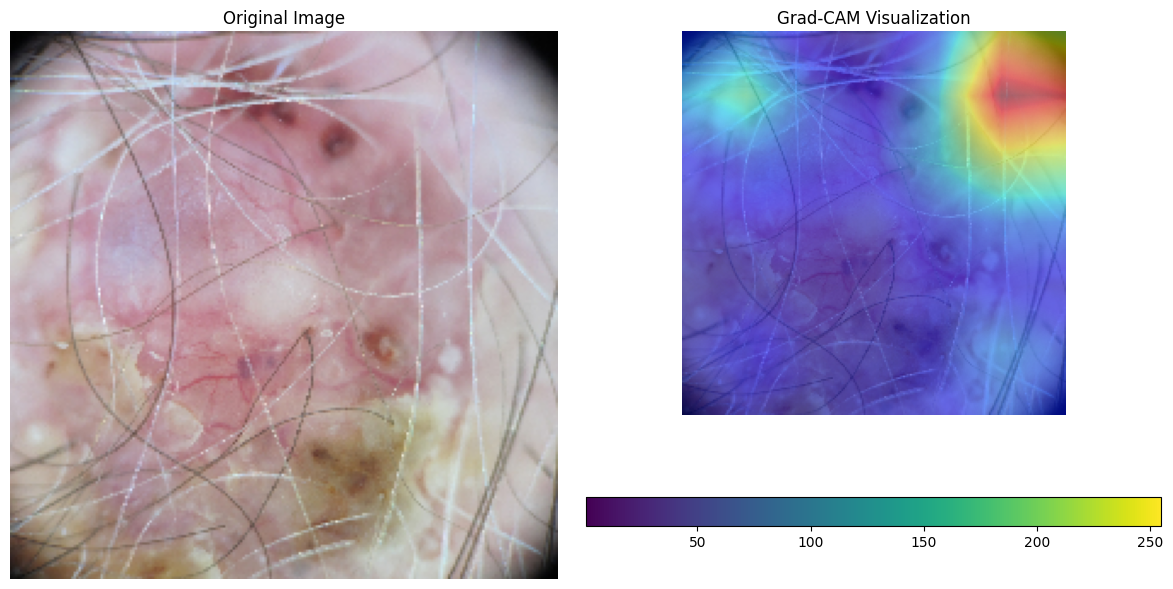

In [43]:

# Load the original image
original_img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))

# Generate Grad-CAM visualization
cam = generate_gradcam(model, img_array, layer_name)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original image
axs[0].imshow(original_img)
axs[0].set_title('Original Image')
axs[0].axis('off')

# Plot the Grad-CAM heatmap overlaid on the original image
heatmap = axs[1].imshow(original_img)
axs[1].imshow(cam[0], cmap='jet', alpha=0.5)
axs[1].set_title('Grad-CAM Visualization')
axs[1].axis('off')

# Add colorbar for the heatmap
plt.colorbar(heatmap, ax=axs[1], orientation='horizontal')

# Show the figure
plt.tight_layout()
plt.show()
